In [28]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import warnings
warnings.filterwarnings('ignore')

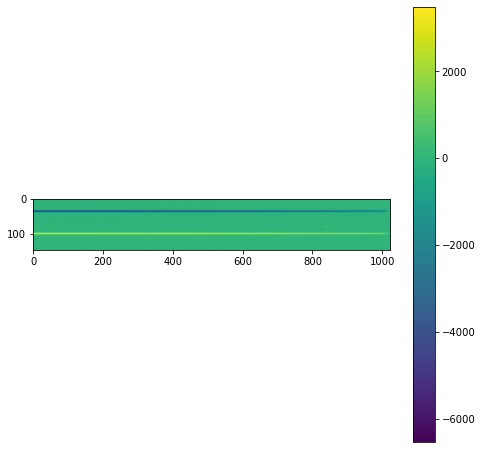

In [17]:
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')


hdu_list1 = fits.open(filepath + 'jun02s0043_order36.fits', ignore_missing_end=True)
hdu_list2 = fits.open(filepath + 'jun02s0044_order36.fits', ignore_missing_end=True)
hdu_list3 = fits.open(filepath + 'jun02s0045_order36.fits', ignore_missing_end=True)
hdu_list4 = fits.open(filepath + 'jun02s0046_order36.fits', ignore_missing_end=True)

hdu_list5 = fits.open(filepath + 'jun02s0047_order36.fits', ignore_missing_end=True)
hdu_list6 = fits.open(filepath + 'jun02s0048_order36.fits', ignore_missing_end=True)
hdu_list7 = fits.open(filepath + 'jun02s0049_order36.fits', ignore_missing_end=True)
hdu_list8 = fits.open(filepath + 'jun02s0050_order36.fits', ignore_missing_end=True)


data1 = hdu_list1[0].data
data2 = hdu_list2[0].data
data3 = hdu_list3[0].data
data4 = hdu_list4[0].data

data5 = hdu_list5[0].data
data6 = hdu_list6[0].data
data7 = hdu_list7[0].data
data8 = hdu_list8[0].data

sum_A = data1 + data4 + data5 + data8
sum_B = data2 + data3 + data6 + data7

plt.figure(figsize=(8,8))
plt.imshow(sum_B - sum_A)
plt.colorbar()

In [18]:
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')


hdu_list1 = fits.getdata(filepath + 'jun02s0043_order36.fits', ignore_missing_end=True)
hdu_list1

array([[ 5.188242  ,  4.350466  ,  6.390901  , ..., -9.368399  ,
        -5.8954244 , -2.3168635 ],
       [ 0.24927677,  0.8078499 ,  3.4401662 , ..., -9.278252  ,
        -8.405757  , -3.6336014 ],
       [ 4.2535133 ,  2.6579125 ,  1.3223948 , ..., -5.625604  ,
        -8.46126   , -7.7280593 ],
       ...,
       [ 5.917216  ,  7.3014283 , -3.6436324 , ..., -6.2416224 ,
        -4.0980515 , -1.2422141 ],
       [ 1.6993958 , -1.6834148 , 12.8724785 , ..., -8.179757  ,
        -0.3472033 , -2.895048  ],
       [-0.16716999,  1.5576917 , -0.9858095 , ..., -2.9071248 ,
        -5.489329  , -3.4456356 ]], dtype=float32)

In [49]:
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')


hdu_list1 = fits.open(filepath + 'jun02s0043_order36.fits', ignore_missing_end=True)

data1 = hdu_list1[0].data
hdu_list1[0]

array([[ 5.188242  ,  4.350466  ,  6.390901  , ..., -9.368399  ,
        -5.8954244 , -2.3168635 ],
       [ 0.24927677,  0.8078499 ,  3.4401662 , ..., -9.278252  ,
        -8.405757  , -3.6336014 ],
       [ 4.2535133 ,  2.6579125 ,  1.3223948 , ..., -5.625604  ,
        -8.46126   , -7.7280593 ],
       ...,
       [ 5.917216  ,  7.3014283 , -3.6436324 , ..., -6.2416224 ,
        -4.0980515 , -1.2422141 ],
       [ 1.6993958 , -1.6834148 , 12.8724785 , ..., -8.179757  ,
        -0.3472033 , -2.895048  ],
       [-0.16716999,  1.5576917 , -0.9858095 , ..., -2.9071248 ,
        -5.489329  , -3.4456356 ]], dtype=float32)

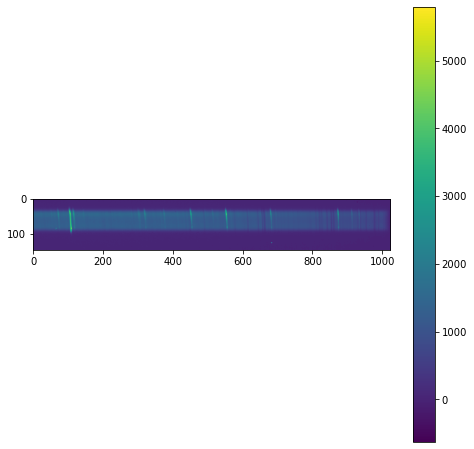

In [78]:
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')


hdu_list1 = fits.open(filepath + 'jun02s0051_order36.fits', ignore_missing_end=True)
hdu_list2 = fits.open(filepath + 'jun02s0052_order36.fits', ignore_missing_end=True)
hdu_list3 = fits.open(filepath + 'jun02s0053_order36.fits', ignore_missing_end=True)
hdu_list4 = fits.open(filepath + 'jun02s0054_order36.fits', ignore_missing_end=True)

hdu_list5 = fits.open(filepath + 'jun02s0055_order36.fits', ignore_missing_end=True)
hdu_list6 = fits.open(filepath + 'jun02s0056_order36.fits', ignore_missing_end=True)
hdu_list7 = fits.open(filepath + 'jun02s0057_order36.fits', ignore_missing_end=True)
hdu_list8 = fits.open(filepath + 'jun02s0058_order36.fits', ignore_missing_end=True)
hdu_list9 = fits.open(filepath + 'jun02s0059_order36.fits', ignore_missing_end=True)


data1 = hdu_list1[0].data
data2 = hdu_list2[0].data
data3 = hdu_list3[0].data
data4 = hdu_list4[0].data

data5 = hdu_list5[0].data
data6 = hdu_list6[0].data
data7 = hdu_list7[0].data
data8 = hdu_list8[0].data
data9 = hdu_list9[0].data

sum_A = data1 + data4 + data5 + data8
sum_B = data2 + data3 + data6 + data7

plt.figure(figsize=(8,8))
plt.imshow(data3 - data1)
plt.colorbar()

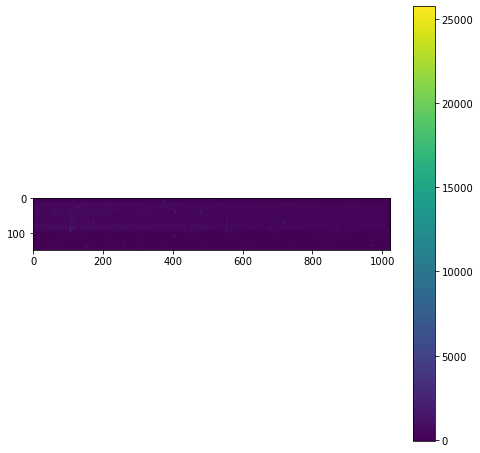

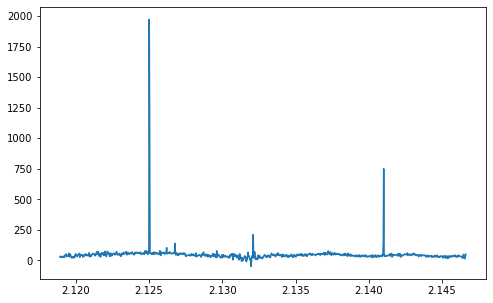

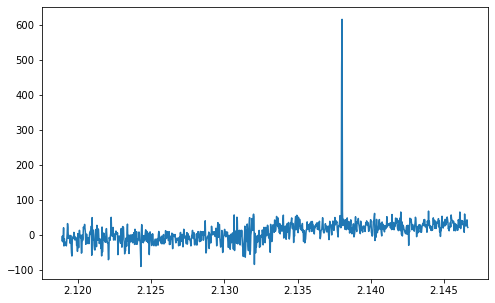

In [18]:
hdul = fits.open(filepath + 'jun02s0065_order36.fits', ignore_missing_end=True)
data = hdul[0].data

plt.figure(figsize=(8,8))
plt.imshow(data)
plt.colorbar()

waverange = fits.open(filepath + 'waverange.fits', ignore_missing_end=True)
wavelength = waverange[0].data

plt.figure(figsize=(8,5))
plt.plot(wavelength, data[1])

ab = sum_A - sum_B
ab[1]

plt.figure(figsize=(8,5))
plt.plot(wavelength, ab[1])

In [86]:
# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

nirspec7_data = []
for i in range(filesize):
    n = i + 22
    if n < 100:
        hdu_data = fits.getdata(filepath + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < 112:
        hdu_data = fits.getdata(filepath + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 112:
        break
nirspec7_data_array = np.array(nirspec7_data)
nirspec7_data_array.shape
#data36
#expected_hdul = [filepath + 'jun02s0' + '{}.fits'.format(i) for i in range(100, 111)]
#actual_hdul = [f for f in expected_hdul if os.path.isfile(f)]
#print (expected_hdul)
#print (actual_hdul)
#print (np.asarray(actual_hdul))

#abba1 = []
#for i in range(0,4):
#    abba1.append(fits.open(actual_hdul[i], ignore_missing_end=True)[0].data)
#np.asarray(abba1).shape
#abba1_sum = sum(abba1)

(90, 148, 1024)

In [ ]:
abba2 = []
for i in range(4,8):
    abba2.append(fits.open(actual_hdul[i], ignore_missing_end=True)[0].data)
abba2_sum = sum(abba2)

plt.figure(figsize=(8,8))
plt.imshow(abba2_sum - abba1_sum)
plt.colorbar()

In [ ]:
for n in range(224): #We use this list to create a list which holds all the data from Order19
    num = n + 76
    if num < 100:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_00' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    elif num < 192 and num >= 100:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_0' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    elif num >= 192 and num < 196:
        print('Star files')
    elif num >= 196 and num < 296:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_0' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    else:
        print('Galaxy files')